## Reconstructing dates from Stream-Duration-Us

This notebook shows an attempt to reconstruct segment dates from the ``Stream-Duration-Us`` values and stream start date. The resulting dates were compared with the ``Ingestion-Walltime-Us`` values. Two streams were considered: (1) an ongoing stream and (2) a stream from its start. These streams are:

1) *Webcam Trévou-Tréguignec* (https://www.youtube.com/watch?v=W72sDmsqbT8)
2) *Randolph Invitational 2023 - Oct 14, 2023 - John Hunt Running Park - Huntsville, AL* (https://www.youtube.com/watch?v=sMF1XHrETEQ)


In [1]:
from datetime import datetime, timedelta, timezone
from pathlib import Path
from zoneinfo import ZoneInfo

import numpy as np
import pandas as pd

from src.display import display_video_frame_at, display_first_video_frame, display_last_video_frame

%load_ext autoreload
%autoreload 1

%aimport src.display

In [2]:
SHARED_PATH = Path("./shared/")

## Case 1. From Trévou-Tréguignec

In [3]:
!grep -a 'Ingestion-Walltime-Us\|Stream-Duration-Us' "$SHARED_PATH"/tre-2408284-i244.webm

In [4]:
metadata_ingestion_walltime = datetime.fromtimestamp(1697121675215683 / 1e6, tz=timezone.utc)
print(metadata_ingestion_walltime)

2023-10-12 14:41:15.215683+00:00


In [5]:
metadata_stream_duration = timedelta(microseconds=12025644257533)
metadata_stream_duration

datetime.timedelta(days=139, seconds=16044, microseconds=257533)

The main HTML page contains the schema.org ``BroadcastEvent`` item encoded as Microdata:

```html
<span itemprop="publication" itemscope itemtype="http://schema.org/BroadcastEvent">
  <meta itemprop="isLiveBroadcast" content="True">
  <meta itemprop="startDate" content="2023-10-14T12:59:56+00:00">
  <meta itemprop="endDate" content="2023-10-14T13:16:47+00:00">
</span>
```

Here is the corresponding XPath:

    //span[@itemtype="http://schema.org/BroadcastEvent"]/meta[@itemprop="startDate"]/@content


In [6]:
broadcast_start_date = datetime.fromisoformat("2023-05-20T09:44:42+00:00")
print('meta@itemprop="startDate":', broadcast_start_date)

meta@itemprop="startDate": 2023-05-20 09:44:42+00:00


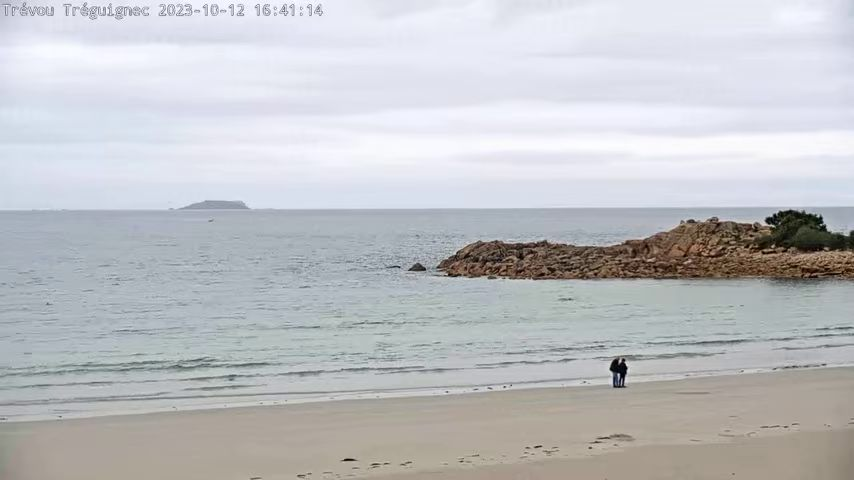

Webcam timestamp: 2023-10-12 16:41:14.900000+02:00


In [7]:
display_first_video_frame(f"{SHARED_PATH}/tre-2408284-i244.webm")
webcam_date = datetime(2023, 10, 12, 16, 41, 14, 900_000, tzinfo=ZoneInfo("Europe/Paris"))
print("Webcam timestamp:", webcam_date)

In [8]:
print("Segment start date")

print("       Webcam timestamp: ", webcam_date.astimezone(timezone.utc))

ingestion_walltime = 1697121675215683
ingestion_date = datetime.fromtimestamp(ingestion_walltime * 1e-6, tz=timezone.utc)
print("  Ingestion-Walltime-Us: ", ingestion_date)

date_from_stream_duration = broadcast_start_date + metadata_stream_duration
print("From Stream-Duration-Us: ", date_from_stream_duration)

Segment start date
       Webcam timestamp:  2023-10-12 14:41:14.900000+00:00
  Ingestion-Walltime-Us:  2023-10-12 14:41:15.215683+00:00
From Stream-Duration-Us:  2023-10-06 14:12:06.257533+00:00


In [9]:
print("Stream duration")
print("  From Stream-Duration-Us:", metadata_stream_duration)
print('  Ingestion-Walltime-Us - @itemprop="startDate":', ingestion_date - broadcast_start_date)

Stream duration
  From Stream-Duration-Us: 139 days, 4:27:24.257533
  Ingestion-Walltime-Us - @itemprop="startDate": 145 days, 4:56:33.215683


As can be seen, for some reason, the segment start dates differ considerably:

In [10]:
print(ingestion_date - date_from_stream_duration)

6 days, 0:29:08.958150


Could it be related to numerous gaps? (It was once observed when a stream stucked with a black screen and a DASH MPD stopped updating for about an hour. So, such gaps could be quite large.) Or did the ``Stream-Duration-Us`` values somehow reset at some point? Anyway, all of this makes it unfortunately impossible to use the ``Stream-Duration-Us`` values to reconstruct segments actual dates.

## Case 2. From Huntsville

Let's look at another stream, now from its beginning.

In the main HTML page:

```html
<span itemprop="publication" itemscope itemtype="http://schema.org/BroadcastEvent">
  <meta itemprop="isLiveBroadcast" content="True">
  <meta itemprop="startDate" content="2023-10-14T12:59:56+00:00">
  <meta itemprop="endDate" content="2023-10-14T13:16:47+00:00">
</span>
```

In [11]:
broadcast_start_date = datetime.fromisoformat("2023-10-14T12:59:56+00:00")
print(broadcast_start_date)

2023-10-14 12:59:56+00:00


The extracted timestamp values for the first three segments:

In [12]:
timestamps = {
    0: {
        "Ingestion-Walltime-Us": 1697288387232156,
        "Stream-Duration-Us": 0,
    },
    1: {
        "Ingestion-Walltime-Us": 1697288390223914,
        "Stream-Duration-Us": 5000000,
    },
    2: {
        "Ingestion-Walltime-Us": 1697288395257537,
        "Stream-Duration-Us": 10000000,
    }
}

In [13]:
first_segment_ingestion_date = datetime.fromtimestamp(
    timestamps[0]["Ingestion-Walltime-Us"] / 1e6,
    tz=timezone.utc
)
print('meta@itemprop="startDate":         ', broadcast_start_date)
print("Ingestion-Walltime-Us (segment 0): ", first_segment_ingestion_date)

meta@itemprop="startDate":          2023-10-14 12:59:56+00:00
Ingestion-Walltime-Us (segment 0):  2023-10-14 12:59:47.232156+00:00


The schema.org ``startDate`` attribute value is 9 seconds later than the ``Ingestion-Walltime-Us`` value of the first segment. Could it be due to a live latency? The stream, in fact, is a normal latency stream.

If we check the ``First-Frame-Time-Us`` value of the segment:

In [14]:
!grep -a "First-Frame-Time-Us" "$SHARED_PATH"/hun-000-i135.mp4

In [15]:
first_segment_first_frame_time = datetime.fromtimestamp(1697288393538735 / 1e6, tz=timezone.utc)
print("First-Frame-Time-Us (segment 0):   ", first_segment_first_frame_time)

First-Frame-Time-Us (segment 0):    2023-10-14 12:59:53.538735+00:00


It falls between two dates compared above:

    Ingestion-Walltime-Us > First-Frame-Time-Us > meta@itemprop="startDate"

In [16]:
for sequence, item in timestamps.items():
    print(f"Segment {sequence}:")
    
    print(
        "    Ingestion-Walltime-Us: ",
        datetime.fromtimestamp(item["Ingestion-Walltime-Us"] / 1e6, tz=timezone.utc),
    )
    print(
        "  From Stream-Duration-Us: ",
        broadcast_start_date + timedelta(microseconds=item["Stream-Duration-Us"]),
    )
    print()

Segment 0:
    Ingestion-Walltime-Us:  2023-10-14 12:59:47.232156+00:00
  From Stream-Duration-Us:  2023-10-14 12:59:56+00:00

Segment 1:
    Ingestion-Walltime-Us:  2023-10-14 12:59:50.223914+00:00
  From Stream-Duration-Us:  2023-10-14 13:00:01+00:00

Segment 2:
    Ingestion-Walltime-Us:  2023-10-14 12:59:55.257537+00:00
  From Stream-Duration-Us:  2023-10-14 13:00:06+00:00



While the gradual increase of 5 seconds of the ``Stream-Duration-Us`` values is clearly seen, the ``Ingestion-Walltime-Us`` values change differently:

In [17]:
ingestion_walltime_values = [timestamps[seq]["Ingestion-Walltime-Us"] for seq in range(3)]
np.diff(ingestion_walltime_values, append=np.nan) / 1e6

array([2.991758, 5.033623,      nan])

In the next notebook, I'm going further in the timeline and see how the timestamp values will evolve for this stream.